# Fraud Detection
## Machine Learning in Python

### This notebook presents some data analysis pipelines with PySpark.
### The dataset used in this example is the [Real or Fake] : Fake Job Description Prediction, which can be dowloaded from [Kaggle](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction).

#### This notebook uses Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Data Exploration

Let's load the dataset into a Pandas Dataframe and perform some data exploration.

In [3]:
dataset_path = './fake_job_postings.csv'
df = pd.read_csv(dataset_path, encoding='utf-8')
df = df.replace([pd.NA, 'NaN', 'nan', 'NULL', 'Null', 'null', '', r'\s+\s*'], np.nan)

In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Let's check the column types, to make sure the dataset was properly loaded.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Let's take a look at the class' distribution.

In [6]:
classes = df['fraudulent'].value_counts().keys().to_list()
print(f'{len(classes)} classes:\n{classes[0]} (real)\n{classes[1]} (fake)\n')

total_records = df.shape[0]
real = df.loc[df['fraudulent'] == 0].count()[0]
print(f'Class rate:\n{classes[0]}: {round(real/total_records*100)}%\n{classes[1]}: {round((1-real/total_records)*100)}%\n')

categorical_features = ['department', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
                        'required_experience', 'required_education', 'industry', 'function']
print(f'Categorical features:\n{", ".join(categorical_features)}\n')

# string_features = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
string_features = ['company_profile', 'description', 'requirements', 'benefits']
print(f'String features:\n{", ".join(string_features)}\n')

2 classes:
0 (real)
1 (fake)

Class rate:
0: 95%
1: 5%

Categorical features:
department, telecommuting, has_company_logo, has_questions, employment_type, required_experience, required_education, industry, function

String features:
company_profile, description, requirements, benefits



We can see a huge imbalance between the number of records which correspond to each class. This can only lead to a huge bias in favor of the real job postings, since they comprise 95% of the dataset.

Now, let's check for NULL values.

In [7]:
pd.DataFrame({'null_count': df.isnull().sum(), 'null_percentage': round(df.isnull().sum() * 100 / df.shape[0],2)})

,null_count,null_percentage
job_id,0,0.00
title,0,0.00
location,346,1.94
department,11547,64.58
salary_range,15012,83.96
company_profile,3308,18.50
description,1,0.01
requirements,2695,15.07
benefits,7210,40.32
telecommuting,0,0.00


We can see that a significant amount out of the 17880 records in this dataset contain NULL values for some features.

For example, as far as the salary range feature is concerned, about 84% of the records are null.

Let's find the exact number of rows with at least one null value.

In [8]:
df.shape[0] - df.dropna().shape[0]

17106

We can see that a 17106 out of the 17880 records in this dataset contain NULL values for some features.

This comprises nearly 96% of the data, which means that only 4% of the data, which is equal to 774 reconds, can be used as is for machine learning purposes.

## Pre-processing

As far as the categorical features are concerned, we need to decide what to do with the missing values. We have the following 5 options:
1. Ignore specific features, especially the ones with more than 50% null values.
2. Replace null values with the most common value.
3. Remove all records with null values.
4. Develop some classifier, e.g. K Nearest Neighbors, to predict the missing values.
5. Develop some clusterer, e.g. K-Means, to group the records and assign values on the missing ones based on the cluster.

In this notebook, we are going to implement options 1 to 3.

We are going to define some functions which will help us with the text preprocessing for the string fields we are going to use in the ML thraining. This preprocessing includes:
* Removing non-alphanumeric characters
* Removing non-digit characters
* Converting text to lowercase
* Expanding contractions
* Performing stemming
* Performing lemmatization
* Removing tabs and redundant whitespaces
* Replacing empty strings, after preprocessing, with the string "empty"

In [9]:
# df['company_profile'].notnull()
# if df['company_profile'][17878] is np.nan:
#     print(df['company_profile'][17878],type(df['company_profile'][17878]),np.nan)

In [10]:
def remove_non_alpanumeric(text):
    """ Removes non-alphanumeric characters """
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return text

def remove_digits(text):
    """ Removes characters which correspond to digits """
    text = re.sub(r'[0-9]', ' ', text)
    return text

def expand_contractions(text, contractions_re, contractions_dict):
    """ Replaces contractions with the full words (e.g. I'll --> I will) """
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

def clean_text(text, contractions_re, contractions_dict, stopwords=None, lemmatizer=None, stemmer=None):
    """ Preprocesses (cleans) text by performing the following operations:
    * Removes non-alphanumeric characters
    * Removes non-digit characters
    * Converts text to lowercase
    * Expands contractions
    * Performs stemming
    * Performs lemmatization
    * Removes tabs and redundant whitespaces
    * Replaces empty strings, after preprocessing, with the string "empty"
    """
    if text and (text.lower() != 'nan') and text is not np.nan:
        text = remove_non_alpanumeric(text)
        text = remove_digits(text)
        text = text.lower()
        text = expand_contractions(text, contractions_re, contractions_dict)
        tokens = nltk.word_tokenize(text)
        if tokens == set():
            print(f'The following text can not be pre-processed: {text}')
        else:
            if stemmer:
                tokens = [stemmer.stem(token) for token in tokens]
            if lemmatizer:
                tokens = [lemmatizer.lemmatize(token) for token in tokens]
            tokens = np.setdiff1d(np.asarray(tokens), np.asarray(stopwords))
            text = ' '.join(tokens)
        
    if not (not text):
        return text
        
    return 'empty'

# Download NLTK tools
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initializes stop words, stemmer and lemmatizer
stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# Dictionary with contractions
contractions_dict = {"ain't": "are not", "'s":" is", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "‘cause": "because", 
                     "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", 
                     "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", 
                     "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "how'd": "how did", "how'd'y": "how do you", 
                     "how'll": "how will", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", 
                     "I've": "I have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", 
                     "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", 
                     "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", 
                     "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                     "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                     "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "that'd": "that would", 
                     "that'd've": "that would have", "there'd": "there would", "there'd've": "there would have", "they'd": "they would", 
                     "they'd've": "they would have","they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                     "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                     "we're": "we are", "we've": "we have", "weren't": "were not","what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                     "what've": "what have", "when've": "when have", "where'd": "where did", "where've": "where have", "who'll": "who will", 
                     "who'll've": "who will have", "who've": "who have", "why've": "why have", "will've": "will have", "won't": "will not", 
                     "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                     "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", 
                     "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Regular expression to identify contractions
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, we are going to implement some functions for applying transformations on the dataframe. These transformations include:
* Replacing null values with the most common value in specified fields
* Transforming categorical string fields to numerical
* Applying string preprocessing to the specified fields

In [11]:
def cat2num(df, categorical_features):
    df_new = df.copy()
    
    for c in categorical_features:
        if df_new[c].dtype != np.int64:
            df_new.loc[:,[c]] = LabelEncoder().fit_transform(df_new[c].astype("category").cat.codes)
            df_new[c].replace(0, np.nan, inplace=True)
    
    return df_new

def replace_null(df, categorical_features):
    """ Replaces null values with the most common value in the respective column """
    df_new = df.copy()
    
    for c in categorical_features:        
        df_new.loc[df_new['fraudulent'] == 0, [c]] = df_new.loc[df_new['fraudulent'] == 0, [c]].fillna(df_new.loc[df_new['fraudulent'] == 0, c].mode()[0])
        df_new.loc[df_new['fraudulent'] == 1, [c]] = df_new.loc[df_new['fraudulent'] == 1, [c]].fillna(df_new.loc[df_new['fraudulent'] == 1, c].mode()[0])
    
    return df_new

def clean_strings(df, string_features):
    """ Applies the text preprocessing function to the dataframe features that are contained in string_features list """
    df_new = df.copy()
    
    for c in string_features:
        df_new.loc[:,[c]] = df_new[df_new[c].astype(str) != 'nan'][c].apply(lambda x: clean_text(str(x), contractions_re, contractions_dict, stopwords, lemmatizer)).astype(str)
    
    return df_new

We can convert categorical features of string type to integer type by emumerating the values of these features.

In [12]:
df = cat2num(df, categorical_features)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               17880 non-null  int64  
 1   title                17880 non-null  object 
 2   location             17534 non-null  object 
 3   department           6333 non-null   float64
 4   salary_range         2868 non-null   object 
 5   company_profile      14572 non-null  object 
 6   description          17879 non-null  object 
 7   requirements         15185 non-null  object 
 8   benefits             10670 non-null  object 
 9   telecommuting        17880 non-null  int64  
 10  has_company_logo     17880 non-null  int64  
 11  has_questions        17880 non-null  int64  
 12  employment_type      14409 non-null  float64
 13  required_experience  10830 non-null  float64
 14  required_education   9775 non-null   float64
 15  industry             12977 non-null 

## Experimentation

The algorithms we are going to evaluate for ML are:
1. Gaussian Naive Bayes
2. Nearest Centroid
3. Preceptron
4. Decision Trees
5. Decision Trees with Bagging through BaggingClassifier
6. Decision Trees with Boosting through AdaBoost-SAME classifier
7. Stochastic Gradient Descent
8. Stochastic Gradient Descent with Bagging through BaggingClassifier
9. Stochastic Gradient Descent with Boosting through AdaBoost-SAME classifier
10. A custom simple sequential deep learning model

We are going to define a function through which we can train a Deep Neural Network for classification.

In [13]:
def build_model(X, y, activation=relu, units=[32], dropout_rate=0.1, learning_rate=0.01):
    """
    Build a Neural Network model based on the data and the parameters
    """
    # Model creation
    model = Sequential()
    
    # Input layer
    model.add(Input(X.shape[1:]))
    
    # Dense (intermediate) layers
    for i in range(len(units)):
        model.add(Dense(units[i], activation=activation))
    
    # Output layer
    model.add(Dense(y.shape[1], activation=softmax))

    # Model compilation and description
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    
    return model

Now we define a function through which we are going to train and evaluate the classifier of our choice.

In [14]:
def evaluate_classifier(classifier, X_train, y_train, X_valid, y_valid):
    """ Trains the selected classifier on the training data, performs prediction on the validation data and returns the scores for al classes """
    # fit the training data on the classifier
    classifier.fit(X_train, y_train)
    
    # predict the labels on validation data
    y_pred = classifier.predict(X_valid).round()
    
    # gather scores
    scores = classification_report(y_valid, y_pred, zero_division=0)
    
    return scores

The features we are going to use for training the ML models:
1. The categorical features, converted from string to numeric type when necessary
2. The string features, for which we use TF-IDF as well as binary vectors which show whether some word(s) exist in the text

### Experiment #1: Ignore all features (columns) with null values.

Let's remove all columns which contains null values. This way neither the class distribition nor the number of records changes.

In [15]:
df_new = df.dropna(how='any', axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            17880 non-null  int64 
 1   title             17880 non-null  object
 2   telecommuting     17880 non-null  int64 
 3   has_company_logo  17880 non-null  int64 
 4   has_questions     17880 non-null  int64 
 5   fraudulent        17880 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 838.2+ KB


Let's perform the evaluation based on the features that are left after having dropped the columns before.

In [16]:
# train features and labels
X = df_new[['telecommuting', 'has_company_logo', 'has_questions']].to_numpy()
y = df_new['fraudulent'].to_numpy()

# split the dataframe into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)


# use Gaussian Naive Bayes classifier
clf = GaussianNB()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Gaussian Naive Bayes scores:')
print(scores)

print('')

# use Nearest Centroid classifier
clf = NearestCentroid()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Nearest Centroid scores:')
print(scores)

print('')

# use Perceptron classifier
clf = Perceptron()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Perceptron scores:')
print(scores)


print('\n')


# use Decision Trees classifier
clf = DecisionTreeClassifier()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Decision Tree classifier scores')
print(scores)

print('')

# use Bagging with Decision Trees classifier
clf = BaggingClassifier(DecisionTreeClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Bagging classifier with Decision Tree classifier scores')
print(scores)

print('')

# use Boosting with Decision Trees classifier
clf = AdaBoostClassifier(DecisionTreeClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('AdaBoost classifier with Decision Tree classifier scores')
print(scores)


print('\n')


# use Stochastic Gradient Descent classifier
clf = SGDClassifier()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Stochastic Gradient Descent classifier scores')
print(scores)

print('')

# use Bagging with Gradient Descent classifier
clf = BaggingClassifier(SGDClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Bagging classifier with Stochastic Gradient Descent classifier scores')
print(scores)

print('')

# use Boosting with Gradient Descent classifier
clf = AdaBoostClassifier(SGDClassifier(), algorithm='SAMME')
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('AdaBoost classifier with Stochastic Gradient Descent classifier scores')
print(scores)

Gaussian Naive Bayes scores:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3405
           1       0.06      0.05      0.05       171

    accuracy                           0.91      3576
   macro avg       0.50      0.50      0.50      3576
weighted avg       0.91      0.91      0.91      3576


Nearest Centroid scores:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      3405
           1       0.15      0.66      0.24       171

    accuracy                           0.80      3576
   macro avg       0.56      0.74      0.56      3576
weighted avg       0.94      0.80      0.86      3576


Perceptron scores:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3405
           1       0.00      0.00      0.00       171

    accuracy                           0.95      3576
   macro avg       0.48      0.50      0.49      3576

Let's see how a simple deep learning model performs.

In [17]:
# Labels --> one-hot encodings
y_train = to_categorical(y_train.reshape([-1, 1]))
y_valid = to_categorical(y_valid.reshape([-1, 1]))

In [18]:
dropout_rate=0.3
learning_rate=0.1
patience=1
batch_size=32
epochs=20
units=[256, 128, 2]

In [19]:
model = build_model(X_train, y_train, relu, units, dropout_rate, learning_rate)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
Total params: 34,184
Trainable params: 34,184
Non-trainable params: 0
_________________________________________________________________


Let's train the model.

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)

model.fit(x=X_train, y=y_train, 
          validation_data=(X_valid, y_valid), 
          batch_size=batch_size, epochs=epochs, 
          callbacks=[early_stopping])

Epoch 1/20
447/447 [==============================] - 2s 5ms/step - loss: 0.1853 - accuracy: 0.9514 - val_loss: 0.1676 - val_accuracy: 0.9522
Epoch 2/20
447/447 [==============================] - 2s 4ms/step - loss: 0.1667 - accuracy: 0.9514 - val_loss: 0.1700 - val_accuracy: 0.9522


Let's plot the losses.

<AxesSubplot:>

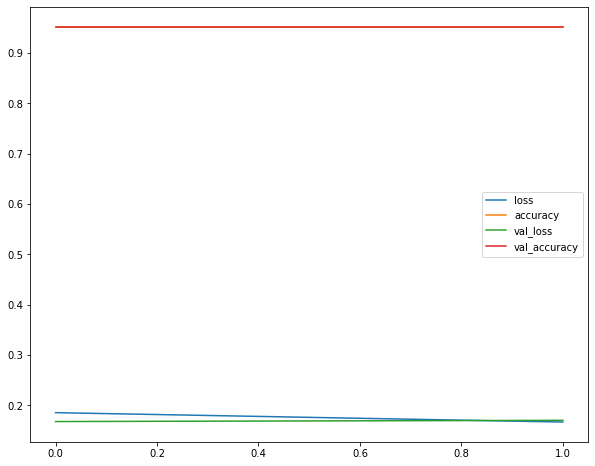

In [21]:
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(10,8))

Let's evaluate our model.

In [22]:
model.evaluate(X_valid, y_valid)

112/112 [==============================] - 0s 4ms/step - loss: 0.1676 - accuracy: 0.9522


[0.16762368381023407, 0.9521812200546265]

In [23]:
# predict the labels on validation dataset
y_pred = model.predict(X_valid).round()

# gather scores
scores = classification_report(y_valid, y_pred, zero_division=0)
print(scores)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3405
           1       0.00      0.00      0.00       171

   micro avg       0.95      0.95      0.95      3576
   macro avg       0.48      0.50      0.49      3576
weighted avg       0.91      0.95      0.93      3576
 samples avg       0.95      0.95      0.95      3576



The deep learning model has the exact same evaluation results as the other simple classifiers.

### Experiment #2: Ignore features (columns) with more than 50% null values and for the remaining columns replace null values with the most common value.

Let's specify the threshold and remove all columns whose null values comprise more than 50% of the entries.

In [24]:
threshold = 0.5
df_new = df.dropna(thresh=df.shape[0]*(1.0-threshold), how='any', axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               17880 non-null  int64  
 1   title                17880 non-null  object 
 2   location             17534 non-null  object 
 3   company_profile      14572 non-null  object 
 4   description          17879 non-null  object 
 5   requirements         15185 non-null  object 
 6   benefits             10670 non-null  object 
 7   telecommuting        17880 non-null  int64  
 8   has_company_logo     17880 non-null  int64  
 9   has_questions        17880 non-null  int64  
 10  employment_type      14409 non-null  float64
 11  required_experience  10830 non-null  float64
 12  required_education   9775 non-null   float64
 13  industry             12977 non-null  float64
 14  function             11425 non-null  float64
 15  fraudulent           17880 non-null 

Let's replace null values with the most common value for the categorical features than remained.

In [25]:
df_new = replace_null(df_new, set(categorical_features)-set(['department']))
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               17880 non-null  int64  
 1   title                17880 non-null  object 
 2   location             17534 non-null  object 
 3   company_profile      14572 non-null  object 
 4   description          17879 non-null  object 
 5   requirements         15185 non-null  object 
 6   benefits             10670 non-null  object 
 7   telecommuting        17880 non-null  int64  
 8   has_company_logo     17880 non-null  int64  
 9   has_questions        17880 non-null  int64  
 10  employment_type      17880 non-null  float64
 11  required_experience  17880 non-null  float64
 12  required_education   17880 non-null  float64
 13  industry             17880 non-null  float64
 14  function             17880 non-null  float64
 15  fraudulent           17880 non-null 

Let's drop the records with null values in the string features we are going to use for training and then perform some text preprocessing on these strings.

In [26]:
df_new.dropna(how='any', subset=string_features, axis=0, inplace=True)
df_new = clean_strings(df_new, string_features)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8846 entries, 1 to 17876
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               8846 non-null   int64  
 1   title                8846 non-null   object 
 2   location             8784 non-null   object 
 3   company_profile      8846 non-null   object 
 4   description          8846 non-null   object 
 5   requirements         8846 non-null   object 
 6   benefits             8846 non-null   object 
 7   telecommuting        8846 non-null   int64  
 8   has_company_logo     8846 non-null   int64  
 9   has_questions        8846 non-null   int64  
 10  employment_type      8846 non-null   float64
 11  required_experience  8846 non-null   float64
 12  required_education   8846 non-null   float64
 13  industry             8846 non-null   float64
 14  function             8846 non-null   float64
 15  fraudulent           8846 non-null   

Let's check the class distribution after dropping all these records.

In [27]:
total_records = df_new.shape[0]
print(f'{total_records} records\n')

classes = df_new['fraudulent'].value_counts().keys().to_list()
print(f'{len(classes)} classes:\n{classes[0]} (real)\n{classes[1]} (fake)\n')

total_records = df_new.shape[0]
real = df_new.loc[df_new['fraudulent'] == 0].count()[0]
print(f'Class rate:\n{classes[0]}: {round(real/total_records*100)}%\n{classes[1]}: {round((1-real/total_records)*100)}%\n')

8846 records

2 classes:
0 (real)
1 (fake)

Class rate:
0: 98%
1: 2%



We can see that we are left with about half the records from the original dataset and that the class imbalance situtation became even worse. From 95% - 5% it became 98% - 2%.

Based on this, we can not expect any reliable and unbiased results from the classification process.

Let's see this for ourselves.

In [28]:
transformer = FeatureUnion([
                ('profile_tfidf',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['company_profile'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('profile_count',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['company_profile'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('description_tfidf',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['description'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('description_count',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['description'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('requirements_tfidf', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['requirements'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('requirements_count', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['requirements'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('benefits_tfidf', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['benefits'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), analyzer='word', max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('benefits_count', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['benefits'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), analyzer='word', max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('telecommuting', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['telecommuting']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('has_company_logo', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['has_company_logo']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('has_questions', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['has_questions']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('employment_type', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['employment_type']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('required_experience', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['required_experience']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('required_education', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['required_education']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('industry', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['industry']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('function', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['function']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
            ])


# train features and labels
train, valid = train_test_split(df_new, test_size=0.2, random_state=13)
X_train = transformer.fit_transform(train.drop(['job_id', 'title', 'location', 'fraudulent'], axis=1)).toarray()
y_train = train['fraudulent'].to_numpy()
X_valid = transformer.transform(valid.drop(['job_id', 'title', 'location', 'fraudulent'], axis=1)).toarray()
y_valid = valid['fraudulent'].to_numpy()


# use Gaussian Naive Bayes classifier
clf = GaussianNB()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Gaussian Naive Bayes scores:')
print(scores)

print('')

# use Nearest Centroid classifier
clf = NearestCentroid()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Nearest Centroid scores:')
print(scores)

print('')

# use Perceptron classifier
clf = Perceptron()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Perceptron scores:')
print(scores)


print('\n')


# use Decision Trees classifier
clf = DecisionTreeClassifier()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Decision Tree classifier scores')
print(scores)

print('')

# use Bagging with Decision Trees classifier
clf = BaggingClassifier(DecisionTreeClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Bagging classifier with Decision Tree classifier scores')
print(scores)

print('')

# use Boosting with Decision Trees classifier
clf = AdaBoostClassifier(DecisionTreeClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('AdaBoost classifier with Decision Tree classifier scores')
print(scores)


print('\n')


# use Stochastic Gradient Descent classifier
clf = SGDClassifier()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Stochastic Gradient Descent classifier scores')
print(scores)

print('')

# use Bagging with Gradient Descent classifier
clf = BaggingClassifier(SGDClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Bagging classifier with Stochastic Gradient Descent classifier scores')
print(scores)

print('')

# use Boosting with Gradient Descent classifier
clf = AdaBoostClassifier(SGDClassifier(), algorithm='SAMME')
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('AdaBoost classifier with Stochastic Gradient Descent classifier scores')
print(scores)

Gaussian Naive Bayes scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1728
           1       1.00      0.83      0.91        42

    accuracy                           1.00      1770
   macro avg       1.00      0.92      0.95      1770
weighted avg       1.00      1.00      1.00      1770


Nearest Centroid scores:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1728
           1       0.06      0.60      0.10        42

    accuracy                           0.75      1770
   macro avg       0.52      0.68      0.48      1770
weighted avg       0.97      0.75      0.84      1770


Perceptron scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1728
           1       0.95      0.95      0.95        42

    accuracy                           1.00      1770
   macro avg       0.98      0.98      0.98      1770

As expected, the resutls were not that great.

However, some classifiers, like Gaussian Naive Bayes, Decision Trees and Stochastic Gradient Descent produce somewhat good results, even if precision and recall are not balanced in most cases.

Also, both bagging and boosting do not offer any significant advantage. To be more precise, they make the classifiers underperform.

Let's see how a simple deep learning model performs.

In [29]:
# Labels --> one-hot encodings
y_train = to_categorical(y_train.reshape([-1, 1]))
y_valid = to_categorical(y_valid.reshape([-1, 1]))

In [30]:
dropout_rate=0.3
learning_rate=0.1
patience=1
batch_size=32
epochs=20
units=[256, 128, 2]

In [31]:
model = build_model(X_train, y_train, relu, units, dropout_rate, learning_rate)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               44520192  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 6         
Total params: 44,553,352
Trainable params: 44,553,352
Non-trainable params: 0
_________________________________________________________________


Let's train the model.

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)

model.fit(x=X_train, y=y_train, 
          validation_data=(X_valid, y_valid), 
          batch_size=batch_size, epochs=epochs, 
          callbacks=[early_stopping])

Epoch 1/20
222/222 [==============================] - 18s 82ms/step - loss: 0.1748 - accuracy: 0.9754 - val_loss: 0.1154 - val_accuracy: 0.9763
Epoch 2/20
222/222 [==============================] - 19s 87ms/step - loss: 0.1130 - accuracy: 0.9764 - val_loss: 0.1125 - val_accuracy: 0.9763
Epoch 3/20
222/222 [==============================] - 19s 84ms/step - loss: 0.1119 - accuracy: 0.9764 - val_loss: 0.1122 - val_accuracy: 0.9763
Epoch 4/20
222/222 [==============================] - 18s 81ms/step - loss: 0.1118 - accuracy: 0.9764 - val_loss: 0.1122 - val_accuracy: 0.9763
Epoch 5/20
222/222 [==============================] - 18s 82ms/step - loss: 0.1118 - accuracy: 0.9764 - val_loss: 0.1122 - val_accuracy: 0.9763


Let's plot the losses.

<AxesSubplot:>

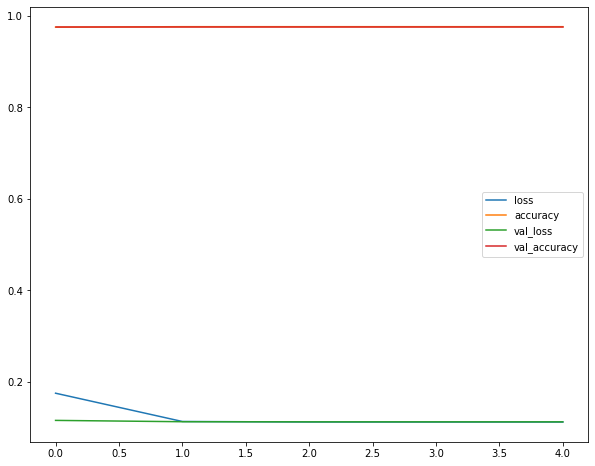

In [33]:
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(10,8))

Let's evaluate our model.

In [34]:
model.evaluate(X_valid, y_valid)

56/56 [==============================] - 2s 34ms/step - loss: 0.1122 - accuracy: 0.9763


[0.11221769452095032, 0.9762712121009827]

In [35]:
# predict the labels on validation dataset
y_pred = model.predict(X_valid).round()

# gather scores
scores = classification_report(y_valid, y_pred, zero_division=0)
print(scores)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1728
           1       0.00      0.00      0.00        42

   micro avg       0.98      0.98      0.98      1770
   macro avg       0.49      0.50      0.49      1770
weighted avg       0.95      0.98      0.96      1770
 samples avg       0.98      0.98      0.98      1770



The deep learning model has about the same evaluation results as the other simple classifiers.

### Experiment #3: Remove all records with null values.

Let's remove all records which contain null values in at least one feature.

In [36]:
df_new = df.dropna(how='any', subset=categorical_features+string_features+['salary_range'], axis=0)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774 entries, 6 to 17865
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               774 non-null    int64  
 1   title                774 non-null    object 
 2   location             774 non-null    object 
 3   department           774 non-null    float64
 4   salary_range         774 non-null    object 
 5   company_profile      774 non-null    object 
 6   description          774 non-null    object 
 7   requirements         774 non-null    object 
 8   benefits             774 non-null    object 
 9   telecommuting        774 non-null    int64  
 10  has_company_logo     774 non-null    int64  
 11  has_questions        774 non-null    int64  
 12  employment_type      774 non-null    float64
 13  required_experience  774 non-null    float64
 14  required_education   774 non-null    float64
 15  industry             774 non-null    f

Let's perform some text preprocessing on the string features of the records that remain.

In [37]:
df_new = clean_strings(df_new, string_features)

salary = df_new['salary_range'].str.split('-', n=1, expand=True)
salary[0] = pd.to_numeric(salary[0], errors='coerce')
salary[1] = pd.to_numeric(salary[1], errors='coerce')
df_new['min_salary'] = salary[0].astype(float)
df_new['max_salary'] = salary[1].astype(float)

df_new.describe()

,job_id,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,7.740000e+02,7.740000e+02
mean,8664.093023,686.856589,0.094315,0.978036,0.673127,2.027132,3.852713,4.184755,57.157623,19.093023,0.093023,1.731337e+06,2.658515e+06
std,5014.106692,349.137620,0.292456,0.146660,0.469374,0.455568,2.188766,2.998615,29.994022,9.349703,0.290653,3.388751e+07,5.180494e+07
min,7.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00
25%,4483.500000,380.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.000000,27.000000,13.000000,0.000000,2.400000e+04,3.120000e+04
50%,8542.000000,734.500000,0.000000,1.000000,1.000000,2.000000,3.000000,2.000000,59.000000,19.000000,0.000000,4.000000e+04,5.450000e+04
75%,12922.250000,1055.000000,0.000000,1.000000,1.000000,2.000000,6.000000,5.000000,76.000000,26.000000,0.000000,6.500000e+04,9.000000e+04
max,17866.000000,1330.000000,1.000000,1.000000,1.000000,5.000000,7.000000,13.000000,131.000000,37.000000,1.000000,8.000000e+08,1.200000e+09


We can see that we are left with about half the records from the original dataset and that the class imbalance situtation became even worse. From 95% - 5% it became 98% - 2%.

Since we are taking into consideration the salary range feature, we need to check whether there exist any outliers in the data.

We can do that using boxplots and distribution plots.

/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

[Text(0.5, 0, 'Salary'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Maximum salary in fake job postings')]

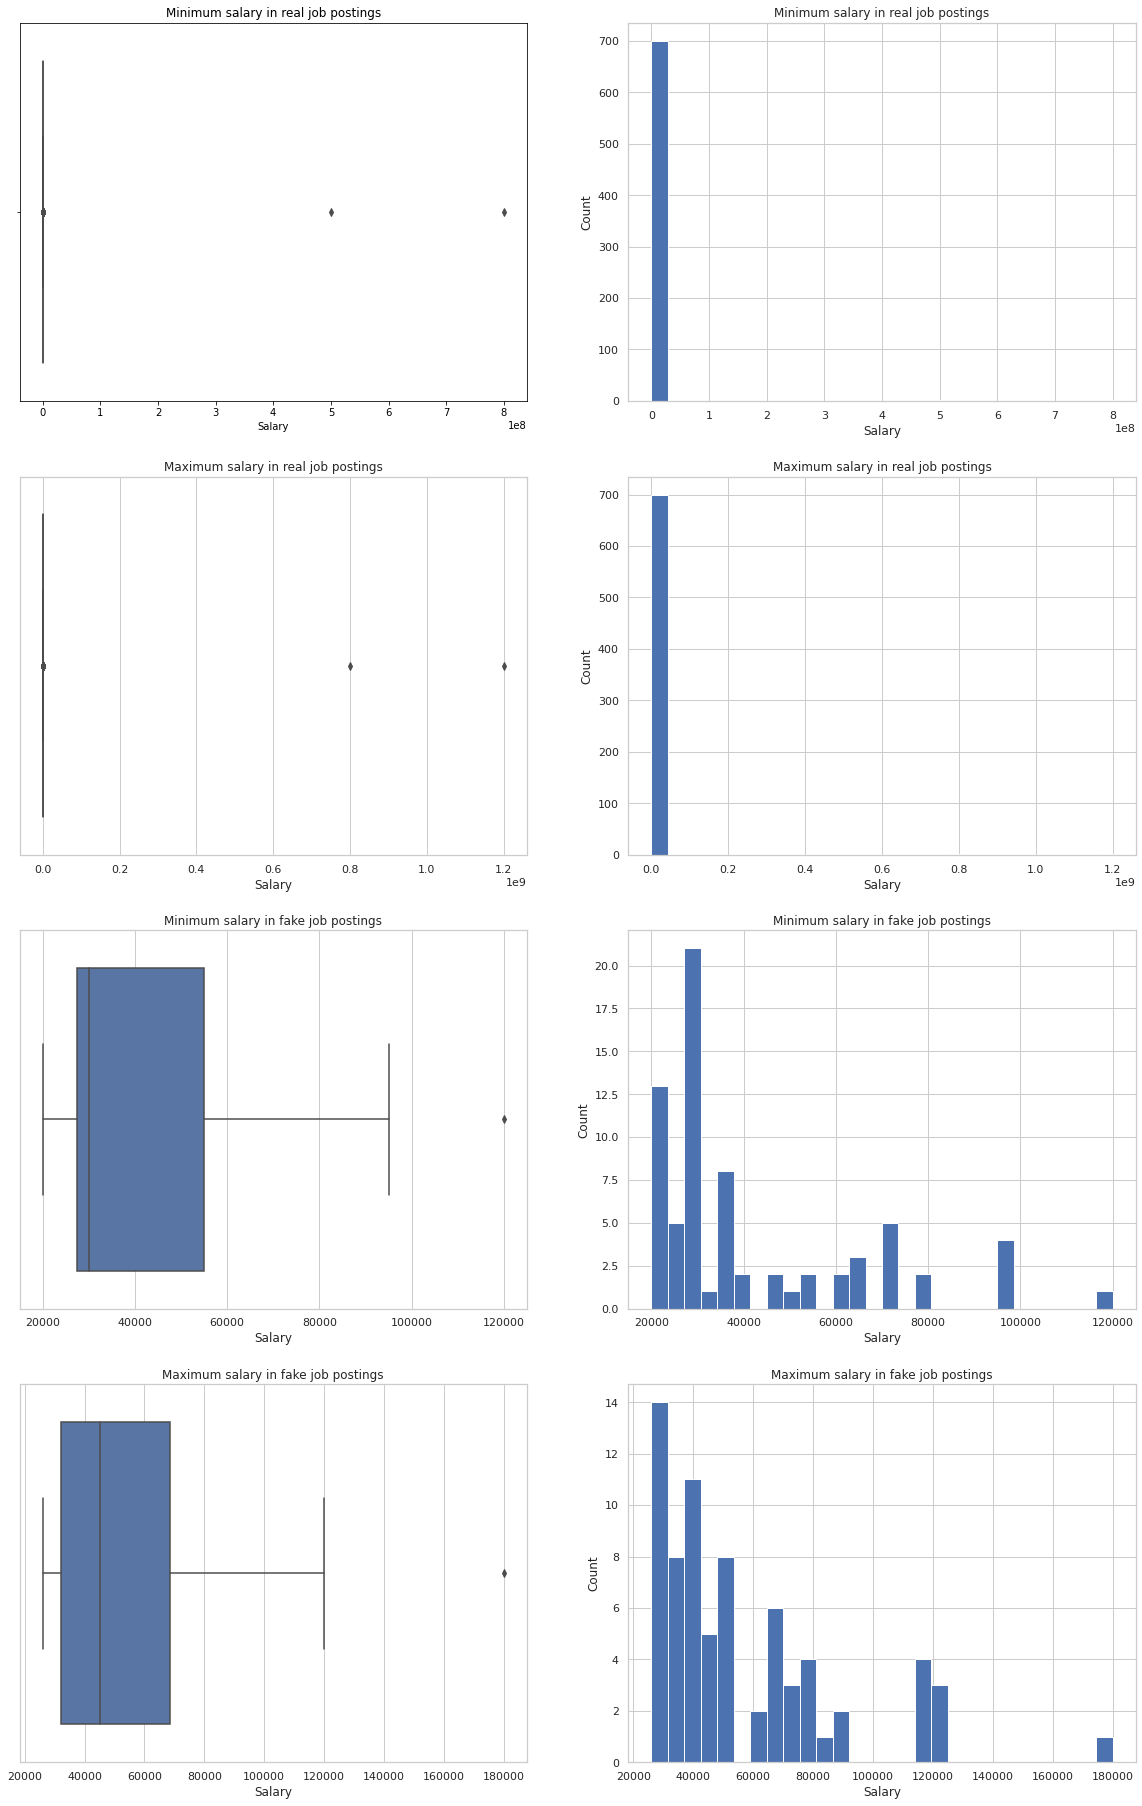

In [38]:
fig, ax = plt.subplots(4, 2, figsize=(20,32))

plt.subplot(4, 2, 1)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary']).set(xlabel='Salary', title='Minimum salary in real job postings')

plt.subplot(4, 2, 2)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in real job postings')

plt.subplot(4, 2, 3)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary']).set(xlabel='Salary', title='Maximum salary in real job postings')

plt.subplot(4, 2, 4)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in real job postings')

plt.subplot(4, 2, 5)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary']).set(xlabel='Salary', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 6)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 7)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary']).set(xlabel='Salary', title='Maximum salary in fake job postings')

plt.subplot(4, 2, 8)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in fake job postings')

Now, we can use the $1.5 \times IQR$ rule to remove outliers.

In [39]:
q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 0, 'min_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minminreal = max(0,q1-1.5*iqr)
maxminreal = max(0,q3+1.5*iqr)
# print(q1,q3,iqr)
# print(minminreal,maxminreal)

q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 0, 'max_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minmaxreal = max(0,q1-1.5*iqr)
maxmaxreal = max(0,q3+1.5*iqr)
# print(q1,q3,iqr)
# print(minmaxreal,maxmaxreal)

# .to_numpy()
q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 1, 'min_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minminfake = max(0,q1-1.5*iqr)
maxminfake = max(0,q3+1.5*iqr)
# print(q1,q3,iqr)
# print(minminfake,maxminfake)

q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 1, 'max_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minmaxfake = max(0,q1-1.5*iqr)
maxmaxfake = max(0,q3+1.5*iqr)
# print(q1,q3,iqr)
# print(minmaxfake,maxmaxfake)

In [40]:
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['min_salary'] < minminreal), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['min_salary'] > maxminreal), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['max_salary'] < minmaxreal), ['max_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['max_salary'] > maxmaxreal), ['max_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['min_salary'] < minminfake), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['min_salary'] > maxminfake), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['max_salary'] < minmaxfake), ['max_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['max_salary'] > maxmaxfake), ['max_salary']] = np.nan

df_new = df_new.dropna(how='any', subset=['min_salary', 'max_salary'], axis=0)

Let's check the result, both from a statistical point of view and through boxplots and distplots.

In [41]:
df_new.describe()

,job_id,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,8612.451389,681.920833,0.098611,0.976389,0.668056,2.029167,3.809722,4.225000,56.320833,19.205556,0.098611,40383.070833,57402.252778
std,5043.050498,353.179535,0.298346,0.151940,0.471239,0.472303,2.195878,3.059346,29.814188,9.430042,0.298346,25862.804109,36469.726350
min,7.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4402.500000,380.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.000000,27.000000,13.000000,0.000000,22000.000000,30000.000000
50%,8556.500000,711.000000,0.000000,1.000000,1.000000,2.000000,3.000000,2.000000,59.000000,19.000000,0.000000,35000.000000,50000.000000
75%,12934.250000,1055.000000,0.000000,1.000000,1.000000,2.000000,6.000000,5.000000,73.000000,27.000000,0.000000,52000.000000,80000.000000
max,17866.000000,1330.000000,1.000000,1.000000,1.000000,5.000000,7.000000,13.000000,127.000000,37.000000,1.000000,125000.000000,180000.000000


In [42]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 6 to 17865
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               720 non-null    int64  
 1   title                720 non-null    object 
 2   location             720 non-null    object 
 3   department           720 non-null    float64
 4   salary_range         720 non-null    object 
 5   company_profile      720 non-null    object 
 6   description          720 non-null    object 
 7   requirements         720 non-null    object 
 8   benefits             720 non-null    object 
 9   telecommuting        720 non-null    int64  
 10  has_company_logo     720 non-null    int64  
 11  has_questions        720 non-null    int64  
 12  employment_type      720 non-null    float64
 13  required_experience  720 non-null    float64
 14  required_education   720 non-null    float64
 15  industry             720 non-null    f

/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/disk/bishop/miniconda3/envs/bd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

[Text(0.5, 0, 'Salary'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Maximum salary in fake job postings')]

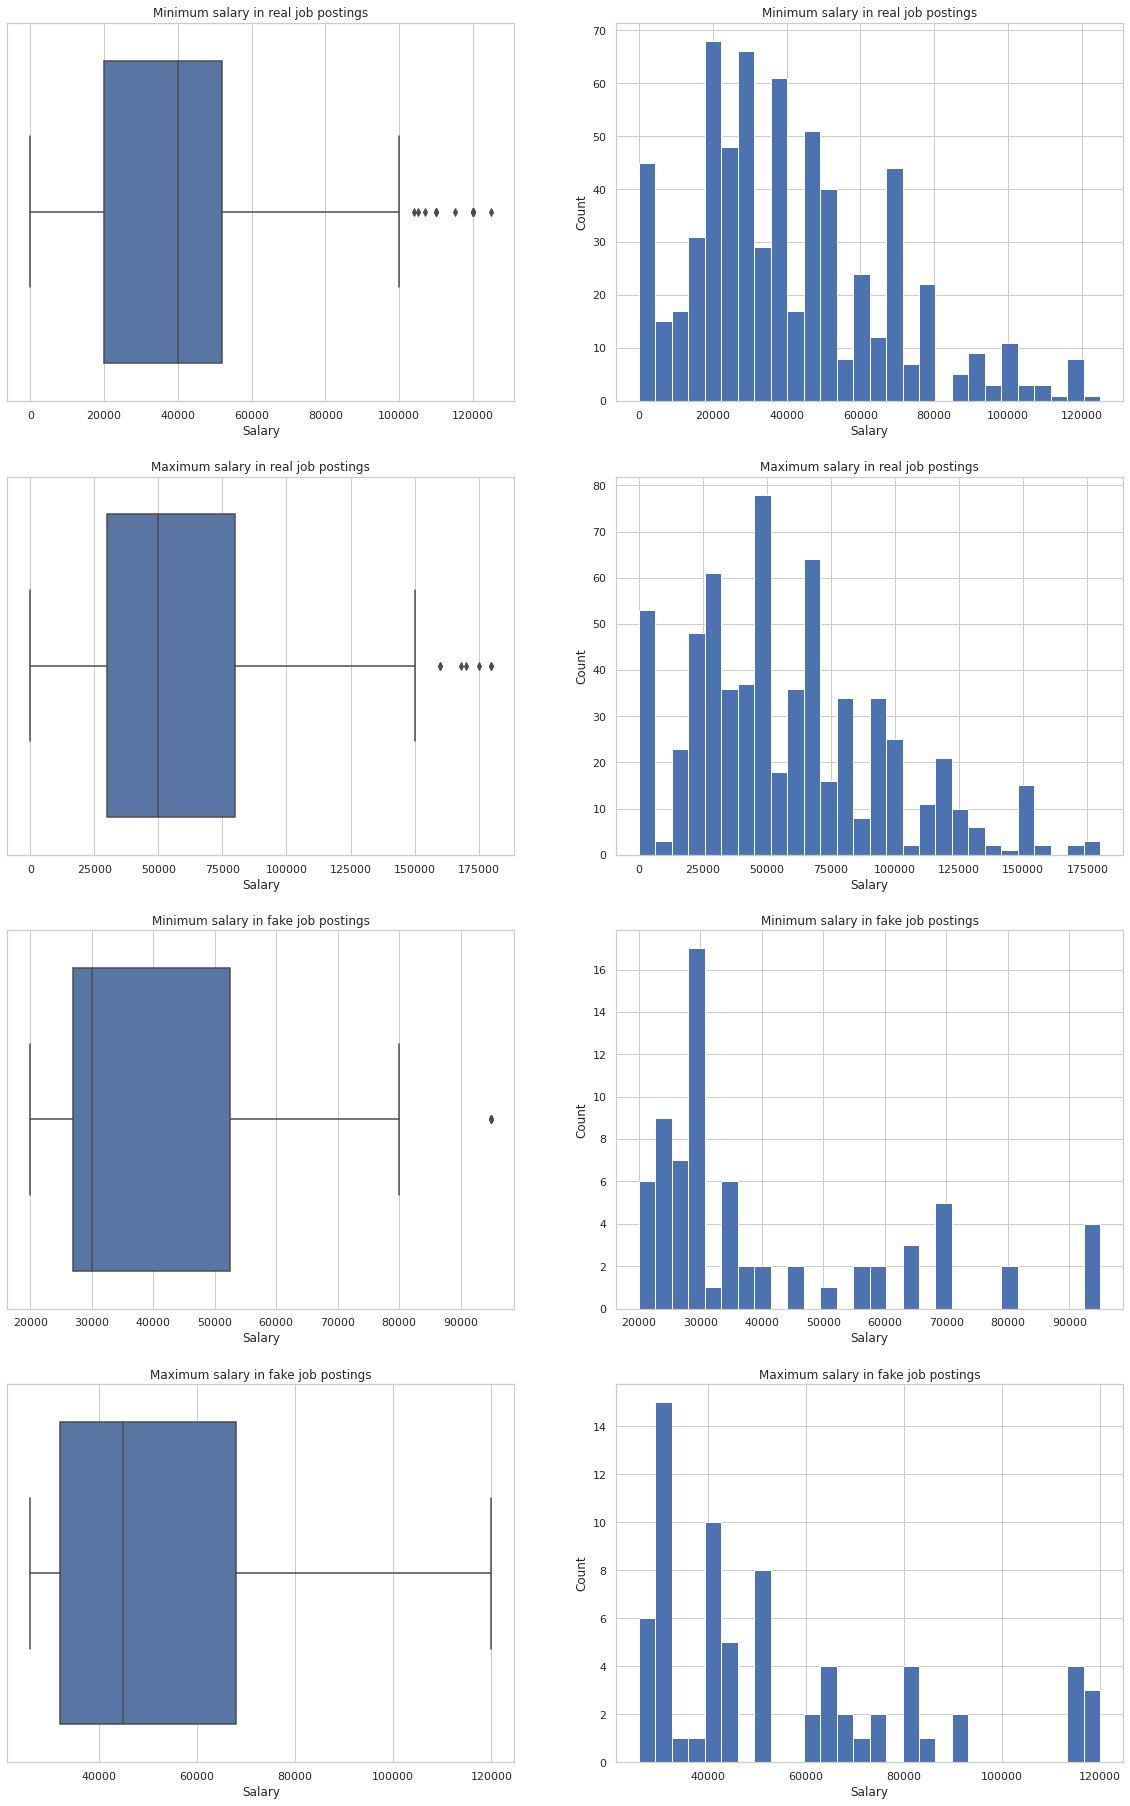

In [43]:
fig, ax = plt.subplots(4, 2, figsize=(20,32))

plt.subplot(4, 2, 1)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary']).set(xlabel='Salary', title='Minimum salary in real job postings')

plt.subplot(4, 2, 2)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in real job postings')

plt.subplot(4, 2, 3)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary']).set(xlabel='Salary', title='Maximum salary in real job postings')

plt.subplot(4, 2, 4)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in real job postings')

plt.subplot(4, 2, 5)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary']).set(xlabel='Salary', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 6)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 7)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary']).set(xlabel='Salary', title='Maximum salary in fake job postings')

plt.subplot(4, 2, 8)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in fake job postings')

Let's check the class distribution after dropping all these records.

In [44]:
total_records = df_new.shape[0]
print(f'{total_records} records\n')

classes = df_new['fraudulent'].value_counts().keys().to_list()
print(f'{len(classes)} classes:\n{classes[0]} (real)\n{classes[1]} (fake)\n')

total_records = df_new.shape[0]
real = df_new.loc[df_new['fraudulent'] == 0].count()[0]
print(f'Class rate:\n{classes[0]}: {round(real/total_records*100)}%\n{classes[1]}: {round((1-real/total_records)*100)}%\n')

720 records

2 classes:
0 (real)
1 (fake)

Class rate:
0: 90%
1: 10%



We can see that we are left with less than 10% of the number of records in the original dataset. On the other hand, the class imbalance situtation is somehow improved, changing from 95% - 5% to 90% - 10%.

Based on this, we are expecting an even worse result than the one from Experiment #2 from the classification process.

Let's see this for ourselves.

In [45]:
transformer = FeatureUnion([
                ('profile_tfidf',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['company_profile'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('profile_count',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['company_profile'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('description_tfidf',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['description'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('description_count',
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['description'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('requirements_tfidf', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['requirements'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('requirements_count', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['requirements'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('benefits_tfidf', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['benefits'], validate=False)),
                            ('tfidf', TfidfVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), analyzer='word', max_df=0.34, min_df=0.001)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('benefits_count', 
                  Pipeline([('extract_text', FunctionTransformer(lambda x: x['benefits'], validate=False)),
                            ('count', CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(2, 3), analyzer='word', max_df=0.34, min_df=0.001, binary=True)),
#                             ('scaler', StandardScaler(with_mean=False))
                           ])),
                ('telecommuting', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['telecommuting']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('department', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['department']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('has_company_logo', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['has_company_logo']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('has_questions', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['has_questions']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('employment_type', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['employment_type']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('required_experience', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['required_experience']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('required_education', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['required_education']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('industry', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['industry']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('function', 
                  Pipeline([('extract_number', FunctionTransformer(lambda x: x[['function']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('min_salary', 
                  Pipeline([('extract_numeric', FunctionTransformer(lambda x: x[['min_salary']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
                ('max_salary', 
                  Pipeline([('extract_numeric', FunctionTransformer(lambda x: x[['max_salary']], validate=False)),
                            ('imputer', SimpleImputer()),
#                             ('scaler', StandardScaler())
                            ])),
            ])


# train features and labels
train, valid = train_test_split(df_new, test_size=0.2, random_state=13)
X_train = transformer.fit_transform(train.drop(['job_id', 'title', 'location', 'fraudulent'], axis=1)).toarray()
y_train = train['fraudulent'].to_numpy()
X_valid = transformer.transform(valid.drop(['job_id', 'title', 'location', 'fraudulent'], axis=1)).toarray()
y_valid = valid['fraudulent'].to_numpy()


# use Gaussian Naive Bayes classifier
clf = GaussianNB()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Gaussian Naive Bayes scores:')
print(scores)

print('')

# use Nearest Centroid classifier
clf = NearestCentroid()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Nearest Centroid scores:')
print(scores)

print('')

# use Perceptron classifier
clf = Perceptron()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Perceptron scores:')
print(scores)


print('\n')


# use Decision Trees classifier
clf = DecisionTreeClassifier()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Decision Tree classifier scores')
print(scores)

print('')

# use Bagging with Decision Trees classifier
clf = BaggingClassifier(DecisionTreeClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Bagging classifier with Decision Tree classifier scores')
print(scores)

print('')

# use Boosting with Decision Trees classifier
clf = AdaBoostClassifier(DecisionTreeClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('AdaBoost classifier with Decision Tree classifier scores')
print(scores)


print('\n')


# use Stochastic Gradient Descent classifier
clf = SGDClassifier()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Stochastic Gradient Descent classifier scores')
print(scores)

print('')

# use Bagging with Gradient Descent classifier
clf = BaggingClassifier(SGDClassifier())
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Bagging classifier with Stochastic Gradient Descent classifier scores')
print(scores)

print('')

# use Boosting with Gradient Descent classifier
clf = AdaBoostClassifier(SGDClassifier(), algorithm='SAMME')
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('AdaBoost classifier with Stochastic Gradient Descent classifier scores')
print(scores)

Gaussian Naive Bayes scores:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       129
           1       0.10      1.00      0.19        15

    accuracy                           0.10       144
   macro avg       0.05      0.50      0.09       144
weighted avg       0.01      0.10      0.02       144


Nearest Centroid scores:
              precision    recall  f1-score   support

           0       0.89      0.44      0.59       129
           1       0.10      0.53      0.17        15

    accuracy                           0.45       144
   macro avg       0.50      0.49      0.38       144
weighted avg       0.81      0.45      0.55       144


Perceptron scores:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       129
           1       0.00      0.00      0.00        15

    accuracy                           0.88       144
   macro avg       0.45      0.49      0.47       144

As expected, the resutls were not that great.

However, some classifiers, like Gaussian Naive Bayes, Decision Trees and Stochastic Gradient Descent produce somewhat good results, even if precision and recall are not balanced in most cases.

Also, both bagging and boosting do not offer any significant advantage. Some times, they improve the performance, while other times they make the classifiers underperform.

Let's see how a simple deep learning model performs.

In [46]:
# Labels --> one-hot encodings
y_train = to_categorical(y_train.reshape([-1, 1]))
y_valid = to_categorical(y_valid.reshape([-1, 1]))

In [47]:
dropout_rate=0.3
learning_rate=0.1
patience=1
batch_size=32
epochs=20
units=[256, 128, 2]

In [48]:
model = build_model(X_train, y_train, relu, units, dropout_rate, learning_rate)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               83667968  
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 6         
Total params: 83,701,128
Trainable params: 83,701,128
Non-trainable params: 0
_________________________________________________________________


Let's train the model.

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)

model.fit(x=X_train, y=y_train, 
          validation_data=(X_valid, y_valid), 
          batch_size=batch_size, epochs=epochs, 
          callbacks=[early_stopping])

Epoch 1/20
18/18 [==============================] - 3s 159ms/step - loss: 4159.0952 - accuracy: 0.8542 - val_loss: 0.4336 - val_accuracy: 0.8958
Epoch 2/20
18/18 [==============================] - 2s 135ms/step - loss: 0.3848 - accuracy: 0.9028 - val_loss: 0.3642 - val_accuracy: 0.8958
Epoch 3/20
18/18 [==============================] - 3s 144ms/step - loss: 0.3426 - accuracy: 0.9028 - val_loss: 0.3447 - val_accuracy: 0.8958
Epoch 4/20
18/18 [==============================] - 3s 143ms/step - loss: 0.3286 - accuracy: 0.9028 - val_loss: 0.3380 - val_accuracy: 0.8958
Epoch 5/20
18/18 [==============================] - 3s 142ms/step - loss: 0.3234 - accuracy: 0.9028 - val_loss: 0.3355 - val_accuracy: 0.8958
Epoch 6/20
18/18 [==============================] - 3s 144ms/step - loss: 0.3212 - accuracy: 0.9028 - val_loss: 0.3346 - val_accuracy: 0.8958
Epoch 7/20
18/18 [==============================] - 2s 137ms/step - loss: 0.3201 - accuracy: 0.9028 - val_loss: 0.3343 - val_accuracy: 0.8958
Epo

Let's plot the losses.

<AxesSubplot:>

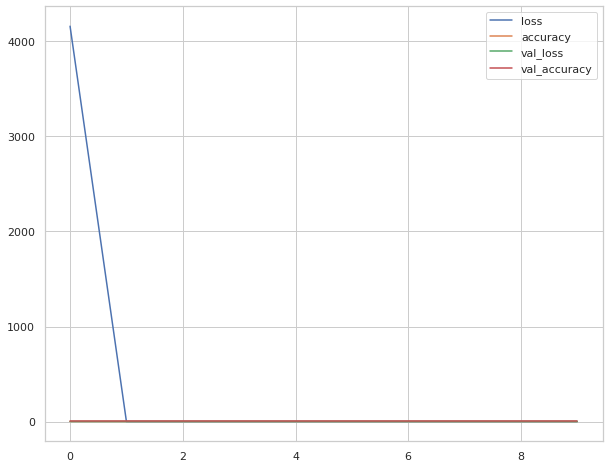

In [50]:
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(10,8))

Let's evaluate our model.

In [51]:
model.evaluate(X_valid, y_valid)

5/5 [==============================] - 0s 54ms/step - loss: 0.3341 - accuracy: 0.8958


[0.3341462314128876, 0.8958333134651184]

In [52]:
# predict the labels on validation dataset
y_pred = model.predict(X_valid).round()

# gather scores
scores = classification_report(y_valid, y_pred, zero_division=0)
print(scores)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       129
           1       0.00      0.00      0.00        15

   micro avg       0.90      0.90      0.90       144
   macro avg       0.45      0.50      0.47       144
weighted avg       0.80      0.90      0.85       144
 samples avg       0.90      0.90      0.90       144



Again, the deep learning model has about the same evaluation results as the other simple classifiers.

### Conclusion

We can see that due to the class imbalance, most of the classifiers we evaluated have trouble producing reliable results, especially for class 1 (fraudulent).

Experiment #2 had the most reliable results, as we can see that for this class precision, recall and f1-score are good for both classes, while in the other 2 experiments these values were zero for class 1.

We can also see that in specific cases bagging and boosting slightly improve the results in Experiment #2, which in the others they made the classifiers produce worse results.